In [1]:
import os
import torch
import torch.nn as nn

import torchvision
from torchvision import transforms
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
class Encoder(nn.Module):
    """
    The encoder part of the U-Net, built from a pretrained ShuffleNetV2.
    It captures features at multiple scales for the skip connections.
    """
    def __init__(self, original_model):
        super().__init__()
        # We take layers directly from the pretrained ShuffleNetV2
        self.conv1 = original_model.conv1
        self.maxpool = original_model.maxpool
        self.stage2 = original_model.stage2
        self.stage3 = original_model.stage3
        self.stage4 = original_model.stage4
        self.conv5 = original_model.conv5

    def forward(self, x):
        # Input: [N, 3, 64, 64]
        s0 = x
        x = self.conv1(x)    # -> [N, 24, 32, 32]
        s1 = x
        x = self.maxpool(x)  # -> [N, 24, 16, 16]
        s2 = x
        x = self.stage2(x)   # -> [N, 116, 8, 8]
        s3 = x
        x = self.stage3(x)   # -> [N, 232, 4, 4]
        s4 = x
        x = self.stage4(x)   # -> [N, 464, 2, 2] (Note: ShuffleNetV2 x1.0 has 464 out channels here)

        # The bottleneck is the final feature map before the fully connected layers
        bottleneck = self.conv5(x) # -> [N, 1024, 2, 2]

        # Return the bottleneck and the skip connections in order from deep to shallow
        return bottleneck, [s4, s3, s2, s1]
    


class DecoderBlock(nn.Module):
    """
    A single block in the decoder path. It concatenates the upsampled features
    with the corresponding skip connection and applies two convolutions.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # The first convolution takes the concatenated feature maps
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
        # Concatenate along the channel dimension
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x
    

class Decoder(nn.Module):
    """
    The decoder part of the U-Net. It takes the bottleneck and skip connections
    from the Encoder and upsamples them to reconstruct the original image.
    """
    def __init__(self, n_classes=3):
        super().__init__()
        # Center (Bottleneck processing)
        self.center_conv = nn.Conv2d(1024, 512, kernel_size=1)

        # Decoder blocks
        # Skip connection channels (from deep to shallow): 232, 116, 24, 24
        self.dec_block1 = DecoderBlock(512, 232, 256)
        self.dec_block2 = DecoderBlock(256, 116, 128)
        self.dec_block3 = DecoderBlock(128, 24, 64)
        self.dec_block4 = DecoderBlock(64, 24, 32)

        # Final output layer
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, bottleneck, skips):
        """
        Args:
            bottleneck (torch.Tensor): The feature map from the deepest part of the encoder.
            skips (list of torch.Tensor): A list of feature maps from the encoder's
                                          skip connections, ordered from deep to shallow.
        """
        # Center
        d = self.center_conv(bottleneck) # -> [N, 512, 2, 2]

        # Decoder path with skip connections
        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 2x2 -> 4x4
        d = self.dec_block1(d, skips[0]) # Use first skip connection

        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 4x4 -> 8x8
        d = self.dec_block2(d, skips[1]) # Use second skip connection

        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 8x8 -> 16x16
        d = self.dec_block3(d, skips[2]) # Use third skip connection

        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 16x16 -> 32x32
        d = self.dec_block4(d, skips[3]) # Use fourth skip connection

        # Final upsampling and convolution
        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 32x32 -> 64x64
        output = self.final_conv(d)

        return torch.sigmoid(output)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the image transformations
image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

image_path = "./data/sample_index_1205_label_24.png" 
try:
    input_image_pil = Image.open(image_path).convert('RGB')
    input_tensor = image_transforms(input_image_pil)
    sample_inputs = input_tensor.unsqueeze(0).to(device)

    print(f"Imagen '{image_path}' cargada y procesada correctamente.")
    print(f"Shape del tensor de entrada para el modelo: {sample_inputs.shape}")

except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar la imagen en la ruta '{image_path}'.")
    print("Por favor, verifica que la ruta y el nombre del archivo son correctos.")

Imagen './data/sample_index_1205_label_24.png' cargada y procesada correctamente.
Shape del tensor de entrada para el modelo: torch.Size([1, 3, 64, 64])


In [5]:
weights = torchvision.models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1
shufflenet_original = torchvision.models.shufflenet_v2_x1_0(weights=weights)

loaded_encoder = Encoder(shufflenet_original)
loaded_decoder = Decoder(n_classes=3)

loaded_encoder.to(device)
loaded_decoder.to(device)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\eduar/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 26.0MB/s]


Decoder(
  (center_conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
  (dec_block1): DecoderBlock(
    (conv1): Conv2d(744, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (dec_block2): DecoderBlock(
    (conv1): Conv2d(372, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inp

In [15]:
model_path = "autoencoder_shufflenet.pth"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

loaded_encoder.load_state_dict(checkpoint['encoder_state_dict'])
loaded_decoder.load_state_dict(checkpoint['decoder_state_dict'])


<All keys matched successfully>

In [16]:
# Use torch.no_grad() to disable gradient calculations for inference
with torch.no_grad():


    # Get the model's reconstructions
    latent_bottleneck, latent_skips = loaded_encoder(sample_inputs)

    print(f"Shape of latent bottleneck: {latent_bottleneck.shape}")
    print(f"Number of skip connections: {len(latent_skips)}")
    print(f"Shapes of skip connections: {[skip.shape for skip in latent_skips]}")

    reconstructed_images = loaded_decoder(latent_bottleneck, latent_skips)

# Move tensors to the CPU and convert to NumPy arrays for plotting
original_image_cpu = sample_inputs.cpu().numpy()
reconstructed_image_cpu = reconstructed_images.cpu().numpy()




Shape of latent bottleneck: torch.Size([1, 1024, 2, 2])
Number of skip connections: 4
Shapes of skip connections: [torch.Size([1, 232, 4, 4]), torch.Size([1, 116, 8, 8]), torch.Size([1, 24, 16, 16]), torch.Size([1, 24, 32, 32])]


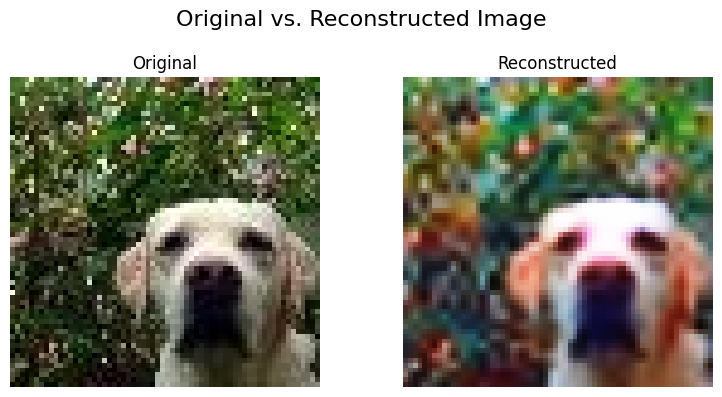

In [17]:
# --- Visualización para una sola imagen ---
plt.figure(figsize=(8, 4))
plt.suptitle("Original vs. Reconstructed Image", fontsize=16)

# Muestra la imagen original
ax = plt.subplot(1, 2, 1)
# Usamos [0] para quitar la dimensión de batch y luego transponemos de (C, H, W) a (H, W, C)
plt.imshow(np.transpose(original_image_cpu[0], (1, 2, 0)))
ax.set_title("Original")

ax.axis("off")

# Muestra la imagen reconstruida
ax = plt.subplot(1, 2, 2)
# Hacemos lo mismo para la imagen reconstruida
plt.imshow(np.transpose(reconstructed_image_cpu[0], (1, 2, 0)))
ax.set_title("Reconstructed")
ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [18]:
bottleneck_cpu = latent_bottleneck.cpu()
skips_cpu = [s.cpu() for s in latent_skips]

# 2. Crear un diccionario para almacenar los tensores.
datos_latentes_para_guardar = {
    'bottleneck': bottleneck_cpu,
    'skips': skips_cpu
}

nombre_archivo_latente = "rep_lat_sample_index_1205_label_24.pth"
torch.save(datos_latentes_para_guardar, nombre_archivo_latente)

In [19]:
# 1. Guardar la imagen de entrada como un tensor
input_tensor_path = "input_tensor.pth"
torch.save(sample_inputs.cpu(), input_tensor_path)

# 2. Guardar la representación latente (bottleneck + skips)
latent_representation = {
    'bottleneck': latent_bottleneck.cpu(),
    'skips': [s.cpu() for s in latent_skips]
}
latent_path = "latent_representation.pth"
torch.save(latent_representation, latent_path)

# 3. Guardar solo el bottleneck (para comparación)
bottleneck_path = "bottleneck_only.pth"
torch.save(latent_bottleneck.cpu(), bottleneck_path)

# 4. Medir los tamaños de los archivos en disco
size_input_kb = os.path.getsize(input_tensor_path) / 1024
size_latent_kb = os.path.getsize(latent_path) / 1024
size_bottleneck_kb = os.path.getsize(bottleneck_path) / 1024

# 5. Imprimir los resultados
print("--- Comparación de Tamaño de Almacenamiento ---")
print(f"Imagen de entrada (tensor): {size_input_kb:.2f} KB")
print(f"Solo el Bottleneck:          {size_bottleneck_kb:.2f} KB")
print(f"Representación Latente Completa (Bottleneck + Skips): {size_latent_kb:.2f} KB")

# Calcular ratios
ratio_completo = size_latent_kb / size_input_kb
ratio_bottleneck = size_bottleneck_kb / size_input_kb

print("\n--- Ratios ---")
print(f"El espacio latente completo ocupa {ratio_completo:.2f} veces el espacio de la imagen de entrada.")
print(f"El bottleneck por sí solo ocupa {ratio_bottleneck:.2f} veces el espacio de la imagen de entrada (compresión).")

# Limpiar los archivos temporales
os.remove(input_tensor_path)
os.remove(latent_path)
os.remove(bottleneck_path)

--- Comparación de Tamaño de Almacenamiento ---
Imagen de entrada (tensor): 49.57 KB
Solo el Bottleneck:          17.59 KB
Representación Latente Completa (Bottleneck + Skips): 182.24 KB

--- Ratios ---
El espacio latente completo ocupa 3.68 veces el espacio de la imagen de entrada.
El bottleneck por sí solo ocupa 0.35 veces el espacio de la imagen de entrada (compresión).
